In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import catboost as cb
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('C:/Users/espit/Documents/Tesis de grado/Base de datos v2/Base de datos insolvencia económica Final.csv', index_col=0, encoding='latin-1', on_bad_lines='skip', sep=';')

In [11]:
df.head()

,Tipo societario,Departamento de la dirección del domicilio,Efectivo y equivalentes al efectivo (CashAndCashEquivalents),Cuentas comerciales por cobrar y otras cuentas por cobrar corrientes (TradeAndOtherCurrentReceivables),Activos corrientes totales (CurrentAssets),Total de activos (Assets),Pasivos corrientes totales (CurrentLiabilities),Total pasivos (Liabilities),Patrimonio total (Equity),Total de patrimonio y pasivos (EquityAndLiabilities),Utilidades,Insolvencia Económica,Patrimonio,Utilidad Neta
NIT,,,,,,,,,,,,,,
800095068,08. SOCIEDAD POR ACCIONES SIMPLIFICADA SAS,BOGOTA D.C.,532129,2606300.0,4953944,10377037,2439350.0,4320823,6056214,10377037,2973734,0,1,1
800210543,01. SOCIEDAD ANÓNIMA,VALLE,72718,574456.0,648528,11296801,551.0,551,11296250,11296801,171944,0,1,1
800215583,01. SOCIEDAD ANÓNIMA,VALLE,6619731,1531139.0,8915142,14478923,1914203.0,2069498,12409425,14478923,1915985,0,1,1
860003057,08. SOCIEDAD POR ACCIONES SIMPLIFICADA SAS,BOGOTA D.C.,199370,933424.0,12133665,45211305,1515619.0,3300443,41910862,45211305,616169,0,1,1
860038652,01. SOCIEDAD ANÓNIMA,BOGOTA D.C.,2819320,173576.0,2992896,20450590,310606.0,1766688,18683902,20450590,1560132,0,1,1


In [262]:
df.isna().sum()

Tipo societario                                                                                             0
Departamento de la dirección del domicilio                                                                  0
Efectivo y equivalentes al efectivo (CashAndCashEquivalents)                                                0
Cuentas comerciales por cobrar y otras cuentas por cobrar corrientes (TradeAndOtherCurrentReceivables)    908
Activos corrientes totales (CurrentAssets)                                                                  0
Total de activos (Assets)                                                                                   0
Pasivos corrientes totales (CurrentLiabilities)                                                           222
Total pasivos (Liabilities)                                                                                 0
Patrimonio total (Equity)                                                                                   0
Total de p

In [3]:
df = df.dropna(subset=['Cuentas comerciales por cobrar y otras cuentas por cobrar corrientes (TradeAndOtherCurrentReceivables)'])
df = df.dropna(subset=['Pasivos corrientes totales (CurrentLiabilities)'])
df['Pasivos corrientes totales (CurrentLiabilities)'] = df['Pasivos corrientes totales (CurrentLiabilities)'].astype('int64')

In [44]:
df.isna().sum()

Tipo societario                                                                                           0
Departamento de la dirección del domicilio                                                                0
Efectivo y equivalentes al efectivo (CashAndCashEquivalents)                                              0
Cuentas comerciales por cobrar y otras cuentas por cobrar corrientes (TradeAndOtherCurrentReceivables)    0
Activos corrientes totales (CurrentAssets)                                                                0
Total de activos (Assets)                                                                                 0
Pasivos corrientes totales (CurrentLiabilities)                                                           0
Total pasivos (Liabilities)                                                                               0
Patrimonio total (Equity)                                                                                 0
Total de patrimonio y pasivo

In [4]:
df['Ventas'] = df['Efectivo y equivalentes al efectivo (CashAndCashEquivalents)'] + df['Cuentas comerciales por cobrar y otras cuentas por cobrar corrientes (TradeAndOtherCurrentReceivables)']
df['Razon Corriente'] = df['Activos corrientes totales (CurrentAssets)'] / df['Pasivos corrientes totales (CurrentLiabilities)']
df['Rentabilidad del activo'] = df['Utilidades'] / df['Pasivos corrientes totales (CurrentLiabilities)']
df['Rentabilidad del Patrimonio'] = df['Utilidades'] / df['Total de activos (Assets)']
df['Nivel de Endeudamiento'] = df['Total pasivos (Liabilities)'] / ((df['Total pasivos (Liabilities)'] + df['Patrimonio total (Equity)']))
df['Apalancamiento Total'] = df['Total pasivos (Liabilities)'] / df['Patrimonio total (Equity)']
df['Relacion Activos y Pasivos'] = df['Total pasivos (Liabilities)'] / df['Total de activos (Assets)']
df['Rotacion Activos'] = df['Ventas'] / df['Total de activos (Assets)']
df['Relacion Activo Corriente y Total Activos'] = df['Activos corrientes totales (CurrentAssets)'] / df['Total de activos (Assets)']
df['Margen Neto'] = df['Utilidades'] / df['Ventas']
df['Apalancamiento a Corto Plazo'] = df['Pasivos corrientes totales (CurrentLiabilities)'] / df['Patrimonio total (Equity)']

In [5]:
df = df.drop(['Efectivo y equivalentes al efectivo (CashAndCashEquivalents)', 'Cuentas comerciales por cobrar y otras cuentas por cobrar corrientes (TradeAndOtherCurrentReceivables)', 'Activos corrientes totales (CurrentAssets)',
              'Total de activos (Assets)', 'Pasivos corrientes totales (CurrentLiabilities)', 'Total pasivos (Liabilities)', 'Patrimonio total (Equity)',
              'Total de patrimonio y pasivos (EquityAndLiabilities)', 'Utilidades','Ventas'], axis=1)

In [7]:
df.isna().sum()

Tipo societario                               0
Departamento de la dirección del domicilio    0
Insolvencia Económica                         0
Patrimonio                                    0
Utilidad Neta                                 0
Razon Corriente                               0
Rentabilidad del activo                       0
Rentabilidad del Patrimonio                   0
Nivel de Endeudamiento                        0
Apalancamiento Total                          0
Relacion Activos y Pasivos                    0
Rotacion Activos                              0
Relacion Activo Corriente y Total Activos     0
Margen Neto                                   0
Apalancamiento a Corto Plazo                  0
dtype: int64

In [7]:
print("Numero de empresas : ",df.shape[0],"\nNumero de variables : ", df.shape[1])
df = df.drop_duplicates()
duplicados = df.duplicated()
print("Numero de filas duplicadas :",len(df[duplicados]))

Numero de empresas :  21990 
Numero de variables :  15
Numero de filas duplicadas : 0


In [239]:
df.describe()

,Insolvencia Económica,Patrimonio,Utilidad Neta,Razon Corriente,Rentabilidad del activo,Rentabilidad del Patrimonio,Nivel de Endeudamiento,Apalancamiento Total,Relacion Activos y Pasivos,Rotacion Activos,Relacion Activo Corriente y Total Activos,Margen Neto,Apalancamiento a Corto Plazo
count,21990.000000,21990.000000,21990.000000,2.199000e+04,21990.000000,21990.000000,21990.000000,21990.000000,21990.000000,21990.000000,21990.000000,2.199000e+04,21990.000000
mean,0.068076,0.959573,0.786949,3.172026e+02,46.588616,0.009402,0.542933,5.415038,0.542933,0.352883,0.567317,NaN,3.429950
std,0.251883,0.196964,0.409473,1.343517e+04,4405.719319,1.492860,1.772304,423.077288,1.772304,0.273107,0.329010,NaN,340.050386
min,0.000000,0.000000,0.000000,0.000000e+00,-15770.474576,-140.998159,0.000002,-24792.971429,0.000002,0.000000,0.000000,-inf,-8277.939614
25%,0.000000,1.000000,1.000000,1.259258e+00,0.009688,0.001937,0.243005,0.251778,0.243005,0.118028,0.262213,8.597195e-03,0.083546
50%,0.000000,1.000000,1.000000,2.102172e+00,0.130878,0.026277,0.473657,0.783997,0.473657,0.301086,0.617008,1.036521e-01,0.392319
75%,0.000000,1.000000,1.000000,4.636803e+00,0.458480,0.076007,0.696346,1.931110,0.696346,0.539903,0.876039,2.775046e-01,1.096897
max,1.000000,1.000000,1.000000,1.524104e+06,613475.000000,80.995192,164.257620,48390.000000,164.257620,1.000000,1.000000,inf,48390.000000


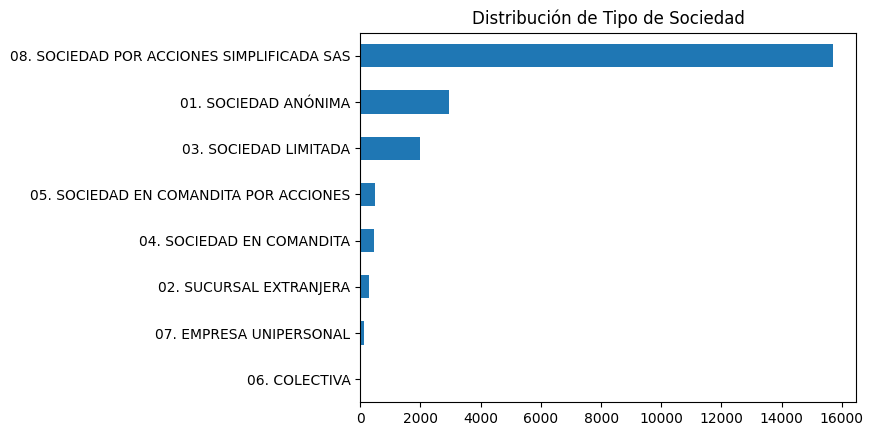

In [75]:
df['Tipo societario'].value_counts().sort_values(ascending=True).plot.barh()
plt.title("Distribución de Tipo de Sociedad")
plt.show()

In [193]:
tipo_sociedad_dict = {'08. SOCIEDAD POR ACCIONES SIMPLIFICADA SAS' : 'SOCIEDAD POR ACCIONES SIMPLIFICADA SAS',
                      '01. SOCIEDAD ANÓNIMA' : 'SOCIEDAD ANÓNIMA',
                      '03. SOCIEDAD LIMITADA' : 'SOCIEDAD LIMITADA',
                      '05. SOCIEDAD EN COMANDITA POR ACCIONES' : 'SOCIEDAD EN COMANDITA POR ACCIONES',
                      '04. SOCIEDAD EN COMANDITA' : 'OTRAS SOCIEDADES',
                      '02. SUCURSAL EXTRANJERA' : 'OTRAS SOCIEDADES',
                      '07. EMPRESA UNIPERSONAL' : 'OTRAS SOCIEDADES',
                      '06. COLECTIVA' : 'OTRAS SOCIEDADES'}
df['Tipo societario'] = df['Tipo societario'].map(tipo_sociedad_dict)

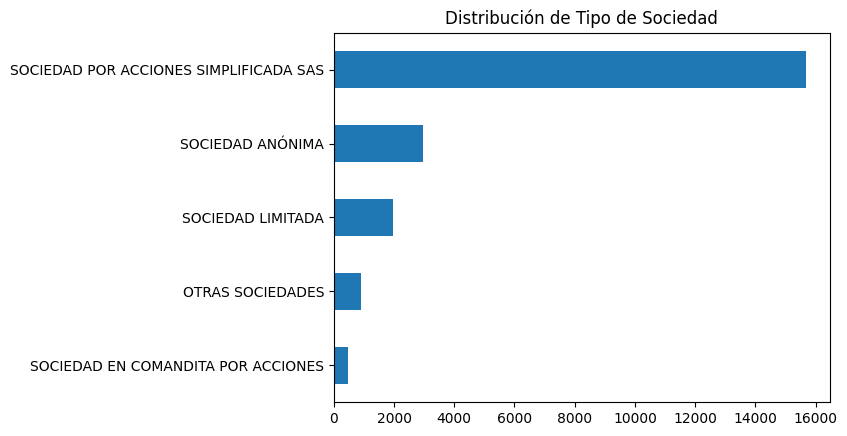

In [194]:
df['Tipo societario'].value_counts().sort_values(ascending=True).plot.barh()
plt.title("Distribución de Tipo de Sociedad")
plt.show()

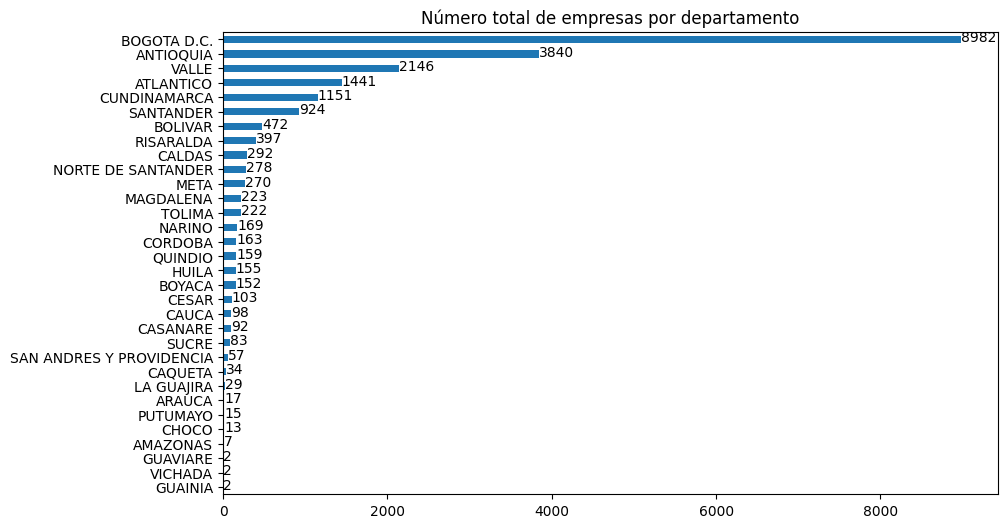

In [78]:
plt.figure(figsize=(10, 6))
ax = df['Departamento de la dirección del domicilio'].value_counts().sort_values(ascending=True).plot.barh()

# Agregar el número total de empresas al final de cada barra horizontal
for i in ax.patches:
    ax.text(i.get_width() + 0.1, i.get_y() + 0.1, str(int(i.get_width())), color='black')

plt.title("Número total de empresas por departamento")
plt.show()

In [79]:
departamento_dict = {'BOGOTA D.C.' : 'BOGOTA',
                     'ANTIOQUIA' : 'ANTIOQUIA',
                     'VALLE' : 'VALLE',
                     'ATLANTICO' : 'ATLANTICO',
                     'CUNDINAMARCA' : 'CUNDINAMARCA',
                     'SANTANDER' : 'SANTANDER',
                     'BOLIVAR' : 'Resto Region Caribe',
                     'CESAR' : 'Resto Region Caribe',
                     'CORDOBA' : 'Resto Region Caribe',
                     'LA GUAJIRA' : 'Resto Region Caribe',
                     'MAGDALENA' : 'Resto Region Caribe',
                     'SAN ANDRES Y PROVIDENCIA' : 'Resto Region Caribe',
                     'SUCRE' : 'Resto Region Caribe',
                     'CALDAS' : 'Eje Cafetero',
                     'QUINDIO' : 'Eje Cafetero',
                     'RISARALDA' : 'Eje Cafetero',
                     'CAUCA' : 'Resto Region Pacifico',
                     'CHOCO' : 'Resto Region Pacifico',
                     'NARINO' : 'Resto Region Pacifico',
                     'AMAZONAS' : 'Region Centro Sur Amazonia',
                     'CAQUETA' : 'Region Centro Sur Amazonia',
                     'HUILA' : 'Region Centro Sur Amazonia',
                     'PUTUMAYO' : 'Region Centro Sur Amazonia',
                     'TOLIMA' : 'Region Centro Sur Amazonia',
                     'NORTE DE SANTANDER' : 'Resto Region Centro Oriente',
                     'BOYACA' : 'Resto Region Centro Oriente',
                     'ARAUCA' : 'Region De Los Llanos',
                     'CASANARE' : 'Region De Los Llanos',
                     'GUAINIA' : 'Region De Los Llanos',
                     'GUAVIARE' : 'Region De Los Llanos',
                     'META' : 'Region De Los Llanos',
                     'VICHADA' : 'Region De Los Llanos'}
df['Departamento de la dirección del domicilio'] = df['Departamento de la dirección del domicilio'].map(departamento_dict)

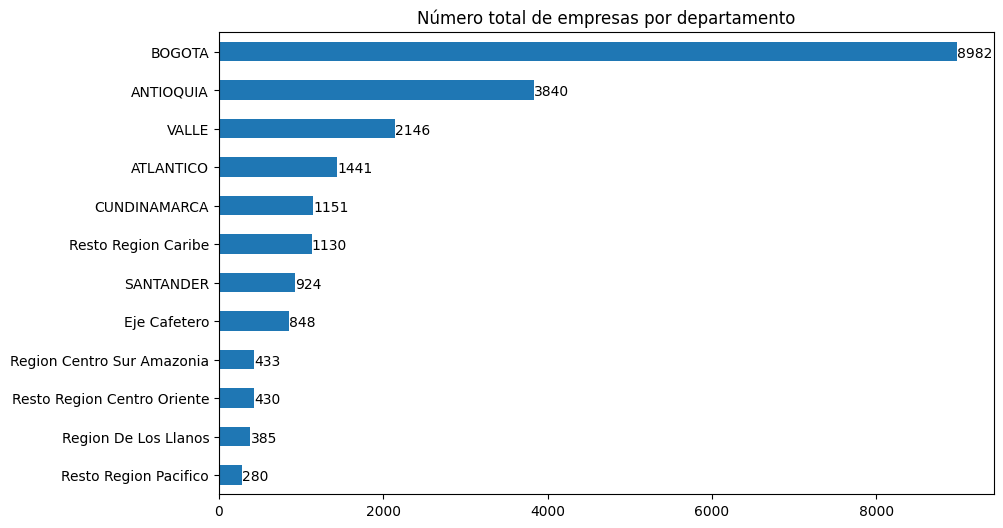

In [80]:
plt.figure(figsize=(10, 6))
ax = df['Departamento de la dirección del domicilio'].value_counts().sort_values(ascending=True).plot.barh()

# Agregar el número total de empresas al final de cada barra horizontal
for i in ax.patches:
    ax.text(i.get_width() + 0.1, i.get_y() + 0.1, str(int(i.get_width())), color='black')

plt.title("Número total de empresas por departamento")
plt.show()

In [81]:
df['Departamento de la dirección del domicilio'].value_counts()

BOGOTA                         8982
ANTIOQUIA                      3840
VALLE                          2146
ATLANTICO                      1441
CUNDINAMARCA                   1151
Resto Region Caribe            1130
SANTANDER                       924
Eje Cafetero                    848
Region Centro Sur Amazonia      433
Resto Region Centro Oriente     430
Region De Los Llanos            385
Resto Region Pacifico           280
Name: Departamento de la dirección del domicilio, dtype: int64

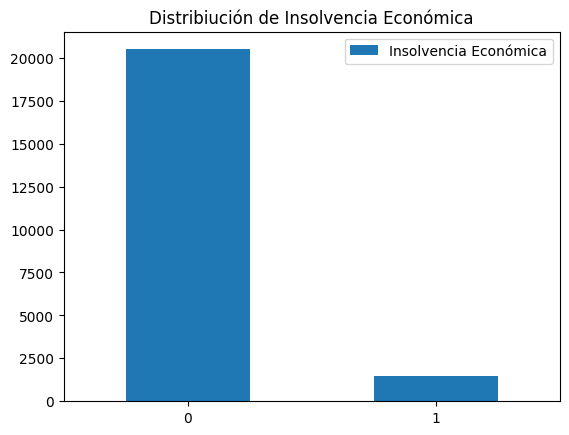

In [82]:
pd.DataFrame(df['Insolvencia Económica'].value_counts()).plot.bar(y='Insolvencia Económica', rot=0)
plt.title("Distribiución de Insolvencia Económica")
plt.show()

C:\Users\espit\AppData\Local\Temp\ipykernel_2276\476429583.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


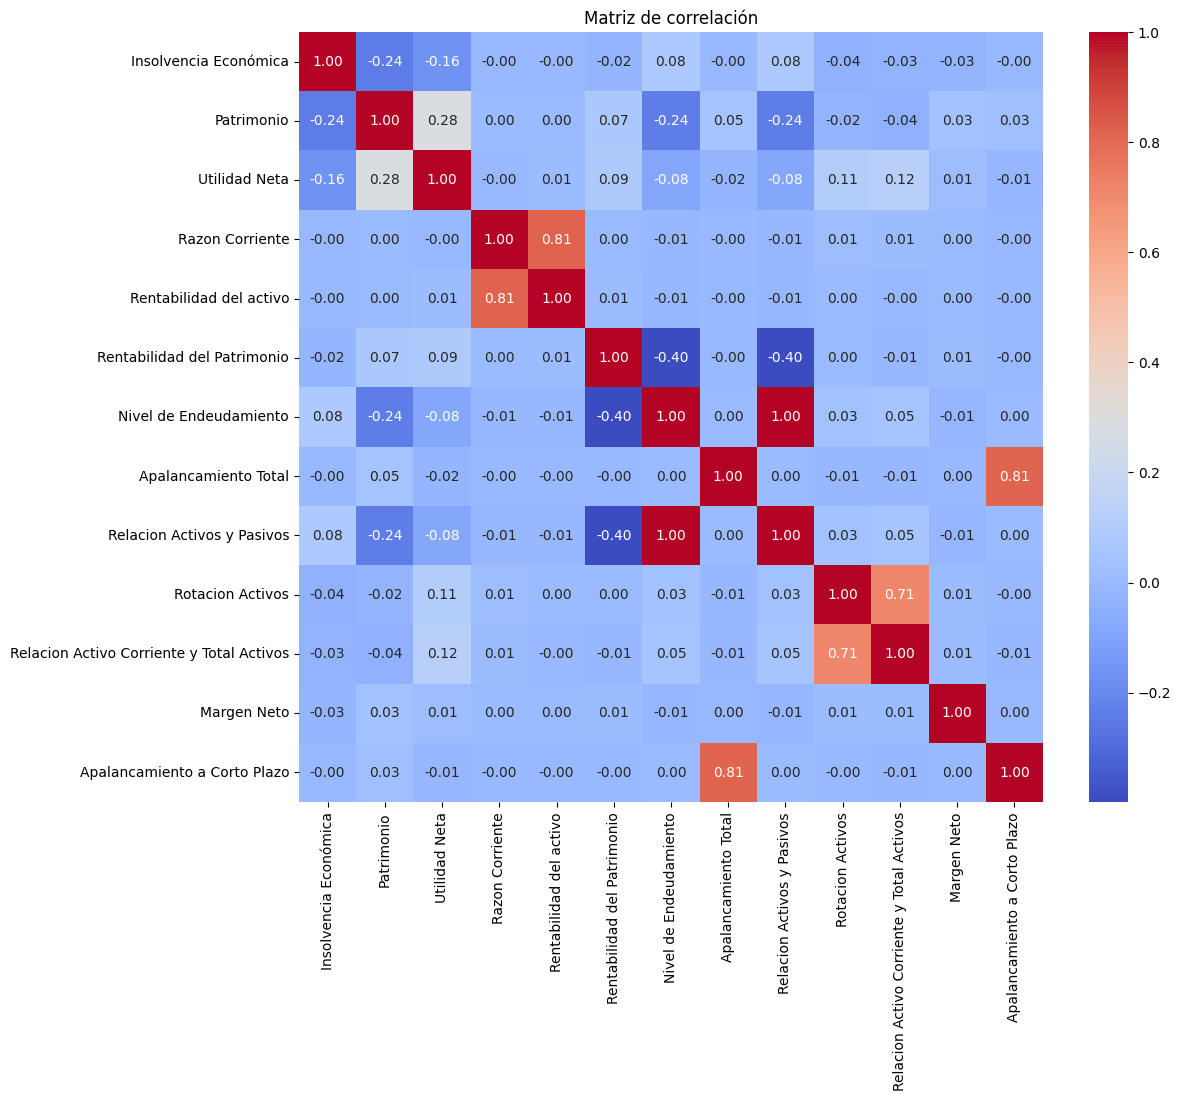

In [8]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación')
plt.show()

C:\Users\espit\AppData\Local\Temp\ipykernel_10376\2186342750.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  insolvencia_corr = pd.DataFrame(df.corr())


<Figure size 1000x600 with 0 Axes>

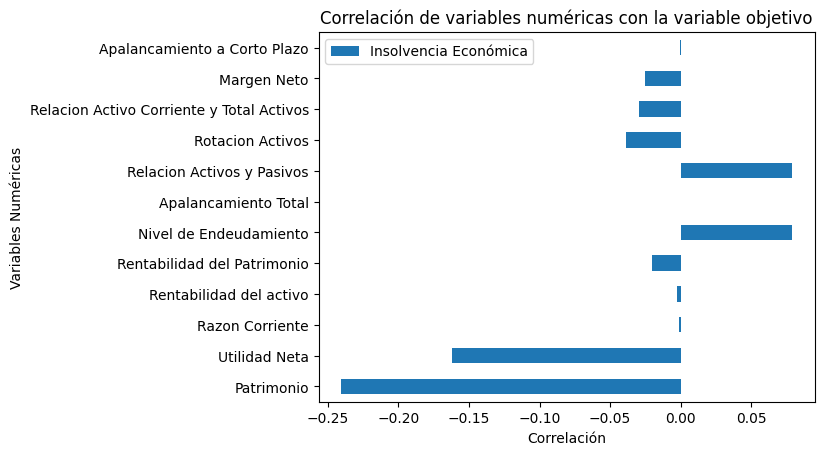

In [43]:
insolvencia_corr = pd.DataFrame(df.corr())
insolvencia_corr = pd.DataFrame(insolvencia_corr['Insolvencia Económica'])

# Remove specific indices
categoricas = ['Insolvencia Económica']
insolvencia_corr = insolvencia_corr.drop(categoricas)

plt.figure(figsize=(10, 6))
ax = insolvencia_corr.plot(kind='barh')

plt.title('Correlación de variables numéricas con la variable objetivo')
plt.xlabel('Correlación')
plt.ylabel('Variables Numéricas')
plt.show()

In [11]:
for key, value in insolvencia_corr.items():
    print(f"{key}: {value}")

Insolvencia Económica: Patrimonio                                  -0.240605
Utilidad Neta                               -0.161849
Razon Corriente                             -0.001023
Rentabilidad del activo                     -0.002528
Rentabilidad del Patrimonio                 -0.020382
Nivel de Endeudamiento                       0.078849
Apalancamiento Total                        -0.000036
Relacion Activos y Pasivos                   0.078849
Rotacion Activos                            -0.038822
Relacion Activo Corriente y Total Activos   -0.029526
Margen Neto                                 -0.025130
Apalancamiento a Corto Plazo                -0.000589
Name: Insolvencia Económica, dtype: float64


In [6]:
# Obtener la matriz de correlación
corr_matrix = df.corr()

# Crear una lista para almacenar las columnas a eliminar
columns_to_drop = []

# Iterar sobre la matriz de correlación
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            column_name = corr_matrix.columns[j]
            columns_to_drop.append(column_name)

# Eliminar las columnas del DataFrame
df.drop(columns=columns_to_drop, inplace=True)

# Imprimir el DataFrame actualizado
df.head(5)

C:\Users\espit\AppData\Local\Temp\ipykernel_19740\3815734501.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


,Tipo societario,Departamento de la dirección del domicilio,Insolvencia Económica,Patrimonio,Utilidad Neta,Razon Corriente,Rentabilidad del activo,Rentabilidad del Patrimonio,Nivel de Endeudamiento,Apalancamiento Total,Rotacion Activos,Relacion Activo Corriente y Total Activos,Margen Neto,Apalancamiento a Corto Plazo
NIT,,,,,,,,,,,,,,
800095068,08. SOCIEDAD POR ACCIONES SIMPLIFICADA SAS,BOGOTA D.C.,0,1,1,2.030846,1.219068,0.286569,0.416383,0.713453,0.302440,0.477395,0.947523,0.402785
800210543,01. SOCIEDAD ANÓNIMA,VALLE,0,1,1,1177.001815,312.058076,0.015221,0.000049,0.000049,0.057288,0.057408,0.265684,0.000049
800215583,01. SOCIEDAD ANÓNIMA,VALLE,0,1,1,4.657365,1.000931,0.132329,0.142932,0.166768,0.562947,0.615732,0.235065,0.154254
860003057,08. SOCIEDAD POR ACCIONES SIMPLIFICADA SAS,BOGOTA D.C.,0,1,1,8.005749,0.406546,0.013629,0.073000,0.078749,0.025056,0.268377,0.543937,0.036163
860038652,01. SOCIEDAD ANÓNIMA,BOGOTA D.C.,0,1,1,9.635667,5.022865,0.076288,0.086388,0.094557,0.146348,0.146348,0.521278,0.016624


In [7]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
#imputer = SimpleImputer(strategy='mean')
#df_imputed = imputer.fit_transform(df)
#scaler = StandardScaler()
#df_scaled = scaler.fit_transform(df_imputed)
#df_scaled = df_scaled.astype(np.float32)

In [8]:
dummies = pd.get_dummies(df['Tipo societario'], drop_first = True)

In [9]:
dummies2 = pd.get_dummies(df['Departamento de la dirección del domicilio'], drop_first = True)

In [10]:
# Añadimos las variables binarias al DataFrame
df = pd.concat([df, dummies], axis = 1)

# Eliminamos la vairable original Primary Type
df = df.drop(columns=['Tipo societario'])

In [11]:
# Añadimos las variables binarias al DataFrame
df = pd.concat([df, dummies2], axis = 1)

# Eliminamos la vairable original Primary Type
df = df.drop(columns=['Departamento de la dirección del domicilio'])

In [18]:
X = df.drop('Insolvencia Económica', axis=1)
y = df['Insolvencia Económica']

In [22]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Definir los hiperparámetros a sintonizar
param_grid = {
    'iterations': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [6, 8, 10],
    'l2_leaf_reg': [1, 5, 10],
    'random_strength': [1, 5, 10]
}

# Definir el modelo CatBoost
model = CatBoostClassifier(random_state=42)

# Realizar la búsqueda de hiperparámetros
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros
print('Mejores hiperparámetros:', grid_search.best_params_)

# Entrenar el modelo con los mejores hiperparámetros
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Evaluar el modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')

# Imprimir la precisión
print('F1-Score:', f1)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


C:\Users\espit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
118 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
118 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\espit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\espit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-

0:	learn: 0.5632167	total: 159ms	remaining: 31.7s
1:	learn: 0.4683680	total: 181ms	remaining: 17.9s
2:	learn: 0.4001284	total: 190ms	remaining: 12.5s
3:	learn: 0.3480813	total: 209ms	remaining: 10.3s
4:	learn: 0.3126642	total: 229ms	remaining: 8.94s
5:	learn: 0.2853962	total: 257ms	remaining: 8.31s
6:	learn: 0.2668556	total: 280ms	remaining: 7.71s
7:	learn: 0.2511215	total: 303ms	remaining: 7.27s
8:	learn: 0.2402215	total: 325ms	remaining: 6.9s
9:	learn: 0.2311800	total: 346ms	remaining: 6.58s
10:	learn: 0.2239902	total: 368ms	remaining: 6.32s
11:	learn: 0.2188231	total: 396ms	remaining: 6.21s
12:	learn: 0.2136640	total: 418ms	remaining: 6.01s
13:	learn: 0.2094793	total: 440ms	remaining: 5.85s
14:	learn: 0.2061103	total: 471ms	remaining: 5.81s
15:	learn: 0.2034472	total: 501ms	remaining: 5.76s
16:	learn: 0.2007830	total: 521ms	remaining: 5.61s
17:	learn: 0.1990197	total: 540ms	remaining: 5.46s
18:	learn: 0.1971529	total: 559ms	remaining: 5.33s
19:	learn: 0.1949518	total: 578ms	remainin

In [23]:
# Imprimir los mejores hiperparámetros
print('Mejores hiperparámetros:', grid_search.best_params_)

Mejores hiperparámetros: {'depth': 8, 'iterations': 200, 'l2_leaf_reg': 10, 'learning_rate': 0.1, 'random_strength': 1}


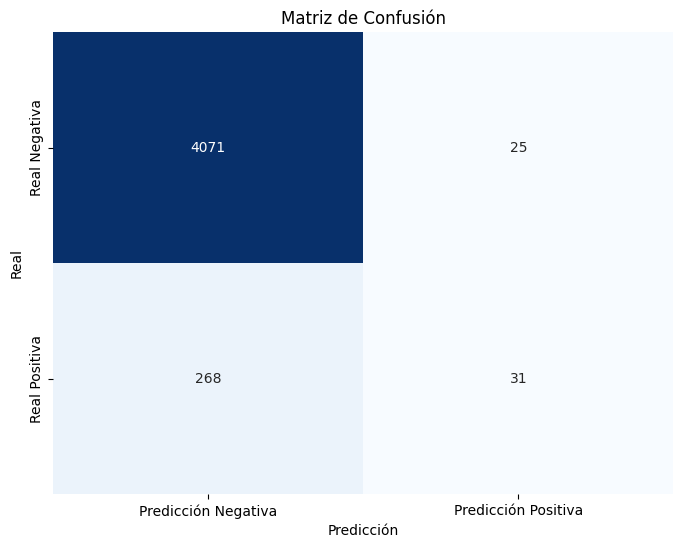

In [24]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicción Negativa', 'Predicción Positiva'],
            yticklabels=['Real Negativa', 'Real Positiva'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [38]:
X = df.drop('Insolvencia Económica', axis=1)
y = df['Insolvencia Económica']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Definir el modelo Random Forest
model = RandomForestClassifier(random_state=42)

# Realizar la búsqueda de hiperparámetros
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros
print('Mejores hiperparámetros:', grid_search.best_params_)

# Entrenar el modelo con los mejores hiperparámetros
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Evaluar el modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')

# Imprimir la precisión
print('F1-Score:', f1)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Mejores hiperparámetros: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}
F1-Score: 0.911185993207396


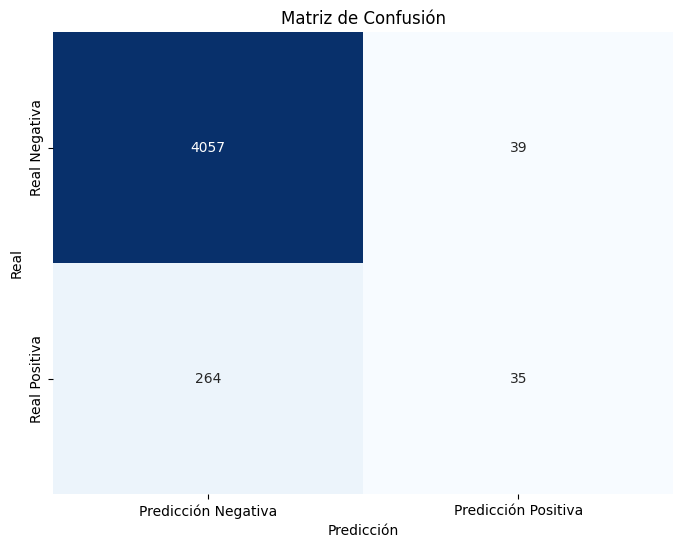

In [40]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicción Negativa', 'Predicción Positiva'],
            yticklabels=['Real Negativa', 'Real Positiva'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [12]:
X = df.drop('Insolvencia Económica', axis=1)
y = df['Insolvencia Económica']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.7, 1.0],
    'contamination': [0.01, 0.05, 0.1],
}

# Crear el modelo Isolation Forest
model = IsolationForest(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros
print('Mejores hiperparámetros:', grid_search.best_params_)

# Entrenar el modelo con los mejores hiperparámetros
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Evaluar el modelo con los mejores hiperparámetros en el conjunto de prueba
y_pred = grid_search.best_estimator_.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')

# Ajustar umbral para mapear la etiqueta
threshold = np.percentile(best_model.decision_function(X_train), 100 * 0.01)

# Mapear etiquetas
labels = np.where(best_model.decision_function(X_train) < threshold, "anomalía", "normal")

# Mostrar resultados
print("Etiquetas originales del modelo:")
print(y_pred)
print("\nEtiquetas mapeadas:")
print(labels)   
print('F1-score:', f1)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\Users\espit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Mejores hiperparámetros: {'contamination': 0.01, 'max_samples': 1.0, 'n_estimators': 200}


C:\Users\espit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Etiquetas originales del modelo:
[1 1 1 ... 1 1 1]

Etiquetas mapeadas:
['normal' 'normal' 'normal' ... 'normal' 'normal' 'normal']
F1-score: 0.008503981797497156


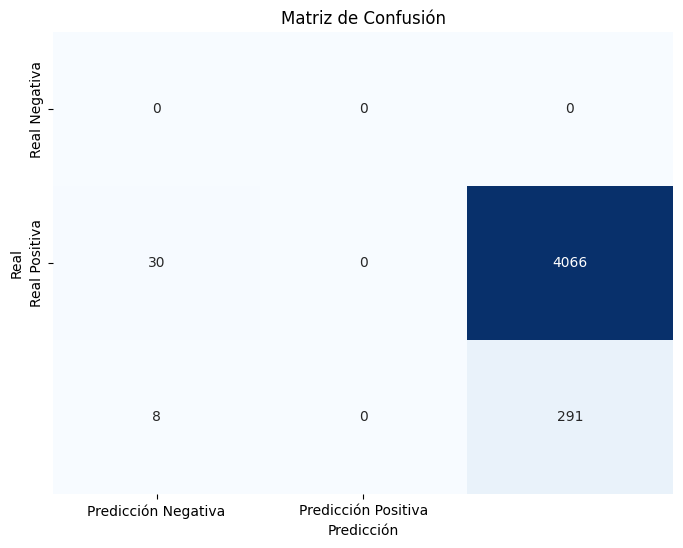

In [23]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicción Negativa', 'Predicción Positiva'],
            yticklabels=['Real Negativa', 'Real Positiva'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()